 MNIST 데이터에 대해서 이해하고, 파이토치(PyTorch)로 **소프트맥스 회귀**를 구현하여 **MNIST 데이터를 분류**하는 실습



MNIST는 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋입니다. 이 데이터는 과거에 우체국에서 편지의 우편 번호를 인식하기 위해서 만들어진 훈련 데이터입니다. 총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 테스트 데이터와 레이블로 구성되어져 있습니다. 레이블은 0부터 9까지 총 10개입니다. 이 예제는 머신 러닝을 처음 배울 때 접하게 되는 가장 기본적인 예제이기도 합니다.

MNIST 문제는 손글씨로 적힌 숫자 이미지가 들어오면, 그 이미지가 무슨 숫자인지 맞추는 문제입니다.

In [2]:
#import
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
print(USE_CUDA)
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

True
다음 기기로 학습합니다: cuda


In [3]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
# hyperparameters
training_epochs = 15
batch_size = 100

In [5]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [6]:
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

In [8]:
from torch.utils import data
print(data_loader)
print(len(data_loader))
# 첫번째 iteration에서 나오는 데이터 확인
images, labels = next(iter(data_loader))
print(images)
print(labels)
print(images.shape, labels.shape) #100개의 samples
#torch.Size([100, 1, 28, 28]) torch.Size([100])
# for x, y in data_loader:
#   print(x, y)


600
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ...

In [9]:
#데이터 시각화
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [10]:
# squeeze() 함수는 차원의 원소가 1인 차원을 없애줍니다.
torch_image = torch.squeeze(images[0])
torch_image.shape


torch.Size([28, 28])

In [11]:
image = torch_image.numpy()
image.shape

(28, 28)

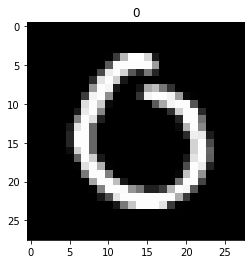

In [12]:
plt.title(labels.numpy()[0])
plt.imshow(image, 'gray')
plt.show()

모델 설계

input_dim = 28*28 = 784
output_dim = 10 (label 갯수)

In [13]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)

비용함수와 옵티마이저 정의

In [14]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

학습

In [15]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.535507977
Epoch: 0002 cost = 0.359549582
Epoch: 0003 cost = 0.331305951
Epoch: 0004 cost = 0.316781074
Epoch: 0005 cost = 0.307441205
Epoch: 0006 cost = 0.300284743
Epoch: 0007 cost = 0.295248330
Epoch: 0008 cost = 0.290644437
Epoch: 0009 cost = 0.287521333
Epoch: 0010 cost = 0.284511566
Epoch: 0011 cost = 0.281797409
Epoch: 0012 cost = 0.279639423
Epoch: 0013 cost = 0.277673542
Epoch: 0014 cost = 0.276035130
Epoch: 0015 cost = 0.274348736
Learning finished


테스트 데이터를 사용하여 모델을 테스트한다.

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor([[  220.7996, -2478.5242,   399.8897,  ...,  2504.4338,   387.5883,
           802.3765],
        [ 1263.5201,  -244.1979,  2747.1382,  ..., -4192.7163,  1580.2018,
         -2219.7859],
        [-1389.4691,  1505.9091,   494.3088,  ...,   -69.4681,   601.6931,
          -286.5315],
        ...,
        [-1865.5787, -1862.8623,  -548.4321,  ...,   288.6782,  1400.7756,
          1241.3086],
        [ -503.3681,  -433.0759,  -398.2752,  ..., -1423.1304,  1731.9954,
          -661.9359],
        [  976.7072, -2663.3357,  1521.2511,  ..., -2167.7966,   460.5699,
          -919.7276]], device='cuda:0')
tensor([7, 2, 1,  ..., 4, 8, 6], device='cuda:0')
tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
tensor([ True,  True,  True,  ...,  True, False,  True], device='cuda:0')
Accuracy: 0.8826999664306641
Label:  8
Prediction:  8


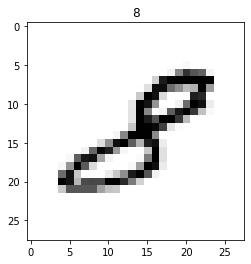

In [16]:
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    print(prediction)
    print(torch.argmax(prediction, dim = 1))
    print(Y_test)
    correct_prediction = torch.argmax(prediction, dim = 1) == Y_test
    print(correct_prediction)
    #torch.argmax(prediction, dim = 1): 열을 없애는것. 각 행에서 가장 큰 값을 갖는 index값만 남음.
    #(100,1)형식의 벡터가 남고, 가장 높은 확률은 갖는 index만 나옴. -> 예측된 숫자값
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    prediction = torch.argmax(single_prediction, 1).item()
    #print(prediction)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.title(prediction)
    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()
